In [35]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import shutil, os

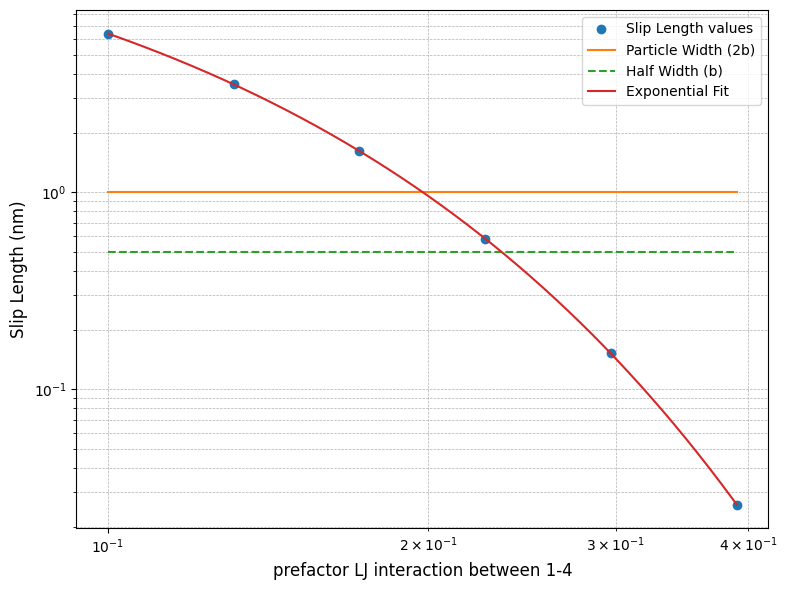

In [36]:
slip_length = []
pref_values = np.logspace(np.log10(0.1), np.log10(0.39), 6)
for prefactor14 in pref_values:
    x, y = np.loadtxt("../../slip-length/slip_lengths_vs_prefactor.dat").T
    def exp_model(x, a, b):
        return a * np.exp(-b * x) # enforce that the slip length can't be negative
    popt, _ = curve_fit(exp_model, x, y, bounds=(0, np.inf))
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = exp_model(x_fit, *popt)
    slip_length_nm = np.round(exp_model(prefactor14, *popt)/10,3)
    slip_length.append(slip_length_nm)
slip_length = np.array(slip_length)
x1 = np.logspace(np.log10(0.1), np.log10(0.39), 1000)
y1 = exp_model(x1, *popt)/10

plt.figure(figsize=(8, 6))
plt.loglog(pref_values, slip_length, "o", label="Slip Length values")
plt.loglog(pref_values, pref_values*0 + 1, "-", label="Particle Width (2b)")
plt.loglog(pref_values, pref_values*0 + 0.5, "--", label="Half Width (b)")
plt.loglog(x1, y1, label="Exponential Fit")
plt.xlabel("prefactor LJ interaction between 1-4", fontsize=12)
plt.ylabel("Slip Length (nm)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_517629/1434093207.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


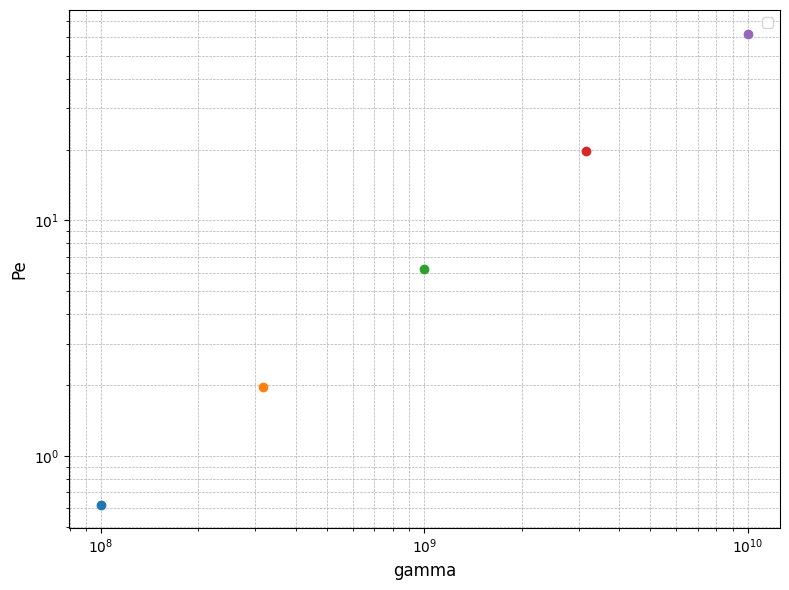

In [37]:
slip_length = []
gamma_values = np.logspace(np.log10(1e8), np.log10(1e10), 5) # s-1
L = 3.2e-9 # m
Dr = (1.38e-23*300)/(2*3.14159*0.001*(L/2)**3) # s-1

plt.figure(figsize=(8, 6))

for gamma in gamma_values:
    Pe = gamma/Dr

    plt.loglog(gamma, Pe, "o")

plt.xlabel("gamma", fontsize=12)
plt.ylabel("Pe", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# PARAMETERS 
typat = 6 # type d atomes
typbo = 1 # type de bond
typan = 1 # type d angle

# Masses
mH = 1.00794
mO = 15.9994
mC = 12.0107

# Parameter for surface geometry
d = 4.04 # Al, Angstroms

# Charges
qO=-1.1128
qH=0.5564
qC=0 # neutral wall and particle

# box boundary
txlo=-22*d
txhi=-txlo
tylo=-3*d
tyhi=-tylo

gamma = 10e9 # s-1
prefactor14 = 0.1

# for gamma in gamma_values:
#for prefactor14 in pref_values: # prefactor for interaction (controls the slip length)

# pore size
n = 44
Hp = n*d
# system size
Hs = (n+4)*d # 4 atoms in wall
# box size 
tzlo=-(n+5)*d/2
tzhi=-tzlo
# particle length
long_length = 30 # Angstrom
# particle exentricity
exentricity = 0.7
small_lenght = long_length * (1-exentricity) # Angstrom

# Add particle and walls - face centered

# initialise counter
nbbond = 0 #nombre bond
nban = 0 # nombre angle
nbat=0 # nombre atome
nbat_wall=0 # nombre atome in wall
nbat_part = 0 # nombre atom in particle
nmol = 1
maille = np.array([[0, 0, 0],
                [d/2, 0, d/2],
                [d/2, d/2, 0],
                [0, d/2, d/2]])

x_max_particle = -1000
x_min_particle = 1000

# place wall and particle atoms in the system
atoms = []
for nx in range(np.int32((txhi - txlo) / d)):
    for ny in range(np.int32((tyhi - tylo) / d)):
        for nz in range(np.int32((tzhi - tzlo) / d)):
            for xyz0 in maille:
                x, y, z = xyz0
                x += txlo
                y += txlo
                z += tzlo - d/4
                x += nx*d
                y += ny*d
                z += nz*d
                if (x/long_length)**2+(z/small_lenght)**2<1: # place particle within ellipse
                    nbat += 1
                    atoms.append([nbat, nmol, 4, qC, x, y, z])
                    nbat_part += 1
                    if x > x_max_particle:
                        x_max_particle = x
                    if x < x_min_particle:
                        x_min_particle = x
                if( z**2 > (Hp/2)**2) & (z**2 <= (Hs/2)**2): # place walls
                    nbat += 1
                    nbat_wall +=1
                    atoms.append([nbat, nmol, 3, qC, x, y, z])

# color the edge atoms
new_atom = []
for atom in atoms:
    nbat, nmol, type, qC, x, y, z = atom
    if type == 4:
        if x == x_min_particle:
            atom = nbat, nmol, 5, qC, x, y, z
        if x == x_max_particle:
            atom = nbat, nmol, 6, qC, x, y, z
    new_atom.append(atom)
atoms = new_atom

atoms_array = np.array(atoms)
print(nbat, "atoms")
print(nbat_wall, "atoms in wall")
print(nbat_part, "atoms in particle")

# Print system information
Actual_Length = np.max(atoms_array[atoms_array[:,2] == 4][:,4]) - np.min(atoms_array[atoms_array[:,2] == 4][:,4])
Actual_width = np.max(atoms_array[atoms_array[:,2] == 4][:,6]) - np.min(atoms_array[atoms_array[:,2] == 4][:,6])
print("PARTICLE DIMENSION")
print("")
print("The actual particle length is", np.round(Actual_Length/10,2), "nm")
print("The actual particle width is", np.round(Actual_width/10,2), "nm")
print("ratio particle over box along x =", np.round(Actual_Length/(txhi-txlo),3))
print("ratio particle over box along z =", np.round(Actual_Length/Hp,3))
print("")
print("BOX DIMENSION")
print("")
print("Box length along x =", np.round((txhi-txlo)/10,3), "nm")
print("Box length along y =", np.round((tyhi-tylo)/10,3), "nm")
print("Box length along z =", np.round((tzhi-tzlo)/10,3), "nm")
print("Initial distance between walls =", np.round(Hp/10), "nm")
print("")
print("SLIP LENGTH")
print("")
print("The prefactor for the interaction is", prefactor14)
x, y = np.loadtxt("../../slip-length/slip_lengths_vs_prefactor.dat").T
def exp_model(x, a, b):
    return a * np.exp(-b * x) # enforce that the slip length can't be negative
popt, _ = curve_fit(exp_model, x, y, bounds=(0, np.inf))
x_fit = np.linspace(min(x), max(x), 100)
y_fit = exp_model(x_fit, *popt)
slip_length_nm = np.round(exp_model(prefactor14, *popt)/10,3)
print("The approximate slip length is", slip_length_nm, "nm")




# Write to log file
with open("README.md", "w") as log:
    log.write("PARTICLE DIMENSION\n\n")
    log.write(f"The actual particle length is {np.round(Actual_Length/10,2)} nm\n")
    log.write(f"The actual particle width is {np.round(Actual_width/10,2)} nm\n")
    log.write(f"ratio particle over box along x = {np.round(Actual_Length/(txhi-txlo),3)}\n")
    log.write(f"ratio particle over box along z = {np.round(Actual_Length/Hp,3)}\n\n")

    log.write("BOX DIMENSION\n\n")
    log.write(f"Box length along x = {np.round((txhi-txlo)/10,3)} nm\n")
    log.write(f"Box length along y = {np.round((tyhi-tylo)/10,3)} nm\n")
    log.write(f"Box length along z = {np.round((tzhi-tzlo)/10,3)} nm\n")
    log.write(f"Initial distance between walls = {Hp/10:.1f} nm\n\n")

    log.write("SLIP LENGTH\n\n")
    log.write(f"The prefactor for the interaction is {prefactor14}\n")
    log.write(f"The approximate slip length is {slip_length_nm} nm\n")

# Replace in inputs
with open('eq.lmp', 'r') as file:
    lines = file.readlines()

with open('eq.lmp', 'w') as file:
    for line in lines:
        if line.strip().startswith('variable Htop equal'):
            file.write(f'variable Htop equal {Hp/2}\n')
        else:
            file.write(line)

with open('parameters.inc', 'r') as file:
    lines = file.readlines()

with open('parameters.inc', 'w') as file:
    for line in lines:
        if line.strip().startswith('variable prefactor14 equal'):
            file.write(f'variable prefactor14 equal {prefactor14}\n')
        else:
            file.write(line)

with open('parameters.inc', 'r') as file:
    lines = file.readlines()

with open('parameters.inc', 'w') as file:
    for line in lines:
        if line.strip().startswith('# for particle-water'):
            file.write(f'# for particle-water (slip length approx {slip_length_nm} nm)\n')
        else:
            file.write(line)

with open('prod.lmp', 'r') as file:
    lines = file.readlines()

with open('prod.lmp', 'w') as file:
    for line in lines:
        if line.strip().startswith('variable gamma_SI equal'):
            file.write(f'variable gamma_SI equal {gamma}\n')
        else:
            file.write(line)

with open('eq.lmp', 'r') as file:
    lines = file.readlines()

with open('eq.lmp', 'w') as file:
    for line in lines:
        if line.strip().startswith('variable gamma_SI equal'):
            file.write(f'variable gamma_SI equal {gamma}\n')
        else:
            file.write(line)

fichier = open("system.data", "w")
# Introduction
fichier.write("#  Water confined in LJ wall. Parameters from 10.1021/la7021787"+ "\n"+ "\n")
fichier.write(str(nbat) + " " + "atoms"+ "\n")
fichier.write(str(nbbond) + " " + "bonds"+ "\n")
fichier.write(str(nban) + " " + "angles"+ "\n")
fichier.write("\n")
fichier.write(str(typat) + " " + "atom types"+ "\n")
fichier.write(str(typbo) + " " + "bond types"+ "\n")
fichier.write(str(typan) + " " + "angle types"+ "\n")
fichier.write("\n")
# Box
fichier.write(str(np.round(txlo,3)) + " " + str(np.round(txhi,3)) + " xlo xhi \n")
fichier.write(str(np.round(tylo,3)) + " " + str(np.round(tyhi,3)) + " ylo yhi \n")
fichier.write(str(np.round(tzlo,3)) + " " + str(np.round(tzhi,3)) + " zlo zhi \n")
fichier.write("\n")
# Masses
fichier.write("Masses \n \n")
fichier.write("1 " + str(mO) + "\n")
fichier.write("2 " + str(mH) + "\n")
fichier.write("3 " + str(mC) + "\n")
fichier.write("4 " + str(mC) + "\n")
fichier.write("5 " + str(mC) + "\n")
fichier.write("6 " + str(mC) + "\n")
fichier.write("\n")
fichier.write("Atoms \n \n")
for atom in atoms:
    fichier.write(str(atom[0]) + " " + str(atom[1]) + " " + str(atom[2]) + " " + str(atom[3]) + " " + str(atom[4]) + " " + str(atom[5]) + " " + str(atom[6])   + "\n")

fichier.write("\n")
fichier.close()

# Files to copy
files_to_copy = ["eq.lmp", "prod.lmp", "groups.lmp", "README.md", "run-cactus.sh",
                    "applyvelocity.lmp", "applypressure.lmp", "system.data", "water.mol",
                    "parameters.inc"]

# Construct folder name
folder_name = f"pref{prefactor14:.2f}_gamma{gamma/1e9:.1f}_2a{Actual_Length/10:.2f}"
folder_path = os.path.join("..", folder_name)

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Copy each file
for file in files_to_copy:
    shutil.copy(file, folder_path)


5424 atoms
4224 atoms in wall
1200 atoms in particle
PARTICLE DIMENSION

The actual particle length is 5.25 nm
The actual particle width is 1.41 nm
ratio particle over box along x = 0.295
ratio particle over box along z = 0.295

BOX DIMENSION

Box length along x = 17.776 nm
Box length along y = 2.424 nm
Box length along z = 19.796 nm
Initial distance between walls = 18.0 nm

SLIP LENGTH

The prefactor for the interaction is 0.1
The approximate slip length is 6.393 nm
